In [1]:
%cd ..

C:\Users\Brown Research\Documents\vr-exoskeleton


In [2]:
%matplotlib ipympl

# trajectory

In [3]:
import datetime
import os

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from vr_exoskeleton import data_utils

In [4]:
users, tasks, user_task_paths = data_utils.get_user_task_paths(ignore_users={'User21'})
len(users)

24

In [5]:
rng = np.random.default_rng()

## Random user, task, and trial

In [6]:
user = rng.choice(users)
task = rng.choice(tasks)
trial = rng.integers(data_utils.N_TRIALS)
print(f'user: {user}; task: {task}; trial: {trial:d}')

# matplotlib and underlying libraries (ipympl, tornado)
#   don't like running the animation at 90Hz.
downsampling_rate = 1

X, _ = data_utils.load_X_Y([user_task_paths[user][task][trial]],
                           downsampling_rate=downsampling_rate,
                           allow_blinks=True)
traj = X[0]
n, m = traj.shape
n, m

user: User19; task: LinearSmoothPursuit; trial: 1


(8095, 9)

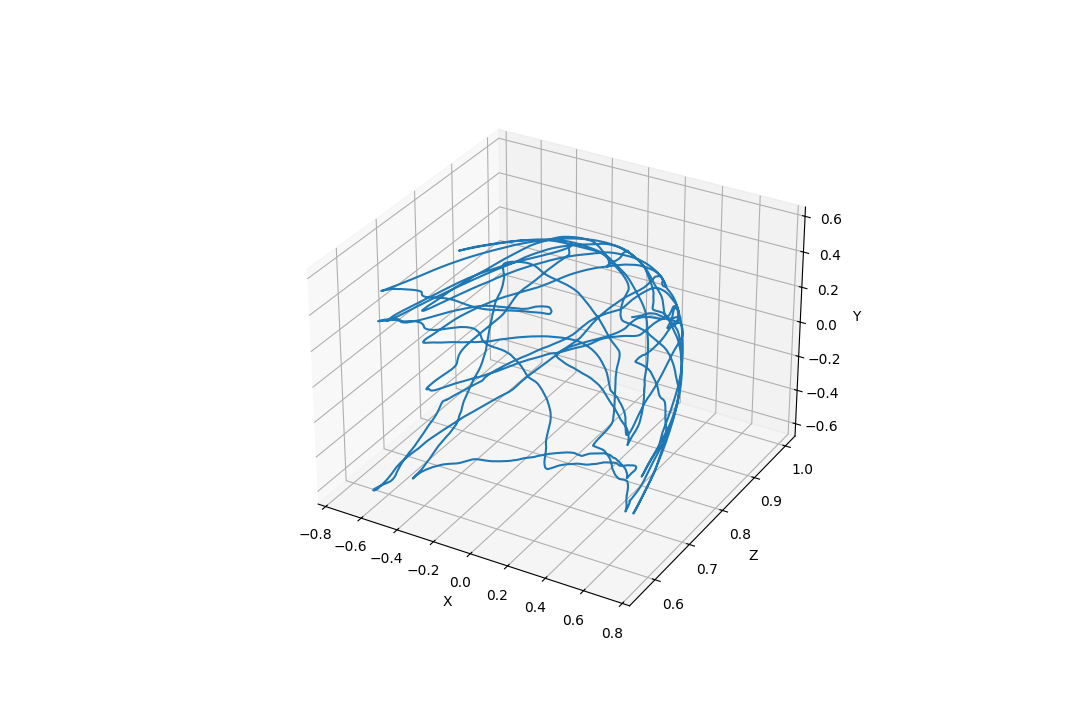

In [7]:
# cmap = mpl.colormaps['viridis']

xs, ys, zs = zip(*traj[:, 6:])

# Swap `y` and `z` axes to proper orientation of game.
plt.close()
fig = plt.figure(figsize=(10.8, 7.2))
ax = fig.add_subplot(projection='3d')
ax.plot(xs, zs, ys)
# ax.scatter(xs, zs, ys, s=1, c=[cmap(v) for v in np.linspace(0, 1, len(xs))])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
# plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10.8, 7.2))
ax_head = fig.add_subplot(121, projection='3d')
x_trail, y_trail, z_trail = list(), list(), list()
line_trail, = ax_head.plot([], [], [], 'r')
len_trail = 90
line_head, = ax_head.plot([], [], [], 'b:')
norm_head = 0.9

ax_gaze = fig.add_subplot(122, projection='3d')
line_gaze_left, = ax_gaze.plot([], [], [], color='magenta', marker='+', linestyle=':')
line_gaze_right, = ax_gaze.plot([], [], [], color='cyan', marker='+', linestyle=':')
eye_radius = 0.2

speedup = 1.


def init():
    for ax in (ax_head, ax_gaze):
        ax.set_xlim(-1, 1)
        ax.set_ylim(-0.1, 1)  # Z
        ax.set_zlim(-1, 1)  # Y
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')

    line_forward = ax_head.plot([0, 0], [0, 1], [0, 0], 'g--')
    line_forward_left = ax_gaze.plot([-eye_radius, -eye_radius], [0, 1], [0, 0], color='yellow', linestyle='--')
    line_forward_right = ax_gaze.plot([eye_radius, eye_radius], [0, 1], [0, 0], color='orange', linestyle='--')
    return line_forward, line_forward_left, line_forward_right


def update(v):
    v_gaze_left, v_gaze_right, v_head = v[:3], v[3:6], v[6:]

    x_, y_, z_ = v_head
    x_trail.append(x_)
    y_trail.append(y_)
    z_trail.append(z_)
    if len(x_trail) > len_trail:
        x_trail.pop(0)
        y_trail.pop(0)
        z_trail.pop(0)
    line_trail.set_data_3d(x_trail, z_trail, y_trail)
    line_head.set_data_3d([0, norm_head * x_], [0, norm_head * z_], [0, norm_head * y_])

    xl_, yl_, zl_ = v_gaze_left
    line_gaze_left.set_data_3d([-eye_radius, xl_ - eye_radius], [0, zl_], [0, yl_])

    xr_, yr_, zr_ = v_gaze_right
    line_gaze_right.set_data_3d([eye_radius, xr_ + eye_radius], [0, zr_], [0, yr_])
    
    return line_trail, line_head, line_gaze_left, line_gaze_right


interval = int(1000 / 90 * downsampling_rate)
animation = FuncAnimation(fig, update, frames=traj, init_func=init,
                          interval=interval, repeat=False, blit=False)
ax_head.set_title('Head Direction')
ax_gaze.set_title('Eye Direction')

path_animation = os.path.join('output', 'images', f'traj_{user}_{task}_{trial:d}_fr{interval:d}.gif')
if not os.path.exists(path_animation):
    animation.save(path_animation)

plt.show()